# Web Scraping Gold and Silver Prices
What's done?
* Using `lxml` to obtain the commodity dates and prices from **investing.com** and convert to `pandas` dataframe. 
* Create command line python programs using `sys.argv`.

# Start Scraping!
Open the webpage and hit `Command`+`Option`+`i`, and move to the price and date elements and right click `Copy` -> `XPath`. The `XPath` is copied and used by `lxml.etree.xpath` to obtain the string values of price and date.

In [119]:
from lxml import etree
import pandas as pd
import requests # for http requests
from datetime import datetime # change date format
import sys
def get_commodity_from_investing(commodity_name): # scrape `date` and `price` from investing.com
    url = "https://www.investing.com/commodities/%s-historical-data"%commodity_name
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}) # add User-Agent to prevent 403 error
    html = response.content
    tree = etree.HTML(html)

    rows = len(tree.xpath('/html/body/div[5]/section/div[9]/table[1]/tbody/tr[*]')) # use * to get all table rows 
    price = [0]*rows
    date = ['']*rows
    for i in range(rows):
        date[i] = date_formatting(tree.xpath('/html/body/div[5]/section/div[9]/table[1]/tbody/tr[%s]/td[1]/text()'%str(i+1))[0]) # index 0 to remove the list item
        price[i] = float(tree.xpath('/html/body/div[5]/section/div[9]/table[1]/tbody/tr[%s]/td[2]/text()'%str(i+1))[0].replace(',',''))
    #gold_date_price = list(zip(date,price)) # zip the two lists into one
    return date,price
def date_formatting(date): # convert Dec 07, 2018 to 2018-12-07
    objDate = datetime.strptime(str(date),'%b %d, %Y') # convert the input string to date objects from a known format
    date = datetime.strftime(objDate,'%Y-%m-%d') # convert the date object to any date format you like!!
    return date

gold_date,gold_price = get_commodity_from_investing('gold')
silver_date,silver_price = get_commodity_from_investing('silver')

# transform list into dataframe
df_gold = pd.DataFrame({'date':gold_date,'gold':gold_price}) 
df_silver = pd.DataFrame({'date':silver_date,'silver':silver_price})
df = df_silver.join(df_gold.set_index('date'),on='date') # join gold on silver since silver has more dates


Save and show the data results

In [120]:
df.to_csv('./data/data.csv')
print(df.head(7))


         date  silver    gold
0  2018-12-07  14.696  1252.6
1  2018-12-06  14.509  1243.6
2  2018-12-05  14.582  1242.6
3  2018-12-04  14.640  1246.6
4  2018-12-03  14.499  1239.6
5  2018-12-02  14.310     NaN
6  2018-11-30  14.217  1226.0


where the NaNs are just missing values. 

# Compute mean and stdev
Create a program to obtain the mean and stdev for a selected date range:

In [164]:
def getCommodityPrice(start_date,end_date,commodity):
    df = pd.read_csv('./data/data.csv')
    mask = (df['date']>=start_date) & (df['date']<=end_date) # alternatively, df[df.some_date.between(start_date, end_date)]
    if not any(mask): 
        raise ValueError("Date out of range %s and %s" % (df['date'].iloc[-1],df['date'].iloc[0]))
    df = df.loc[mask]
    
    return commodity, df[commodity].mean(), df[commodity].std() 

getCommodityPrice('2018-11-07','2018-12-01','gold')

('gold', 1223.0812499999997, 9.434561904685)

Above result shows the mean and standard deviation of the gold commodity. One can create a program `getCommodityPrice.py` which takes commandline inputs and executed as `python getCommodityPrice 2018-11-07 2018-12-01 gold`:

In [162]:
import sys
import pandas as pd
def getCommodityPrice():
    df = pd.read_csv('./data/data.csv')
    mask = (df['date']>=sys.argv[1]) & (df['date']<=sys.argv[2]) # alternatively, df[df.some_date.between(start_date, end_date)]
    if not any(mask): 
        raise ValueError("Date out of range %s and %s" % (df['date'].iloc[-1],df['date'].iloc[0]))
    df = df.loc[mask]
    print(sys.argv[3], df[sys.argv[3]].mean(), df[sys.argv[3]].std())

if __name__ == '__main__': # if module executed directly, then run main()
    getCommodityPrice()

# Predictability

Examine the autocorrelation function (ACF) and partial autocorrelation function (PACF). The PACF(k) estimates the the k coefficients of an lagged autoregression. The lag-k autocorrelation is computed only **up to** lag-k random variable, as opposed to ACF incorporating the >k lags in the OLS computation. This essentially removes the `memory` from , see [here](https://stats.stackexchange.com/questions/18599/pacf-manual-calculation) for more details.

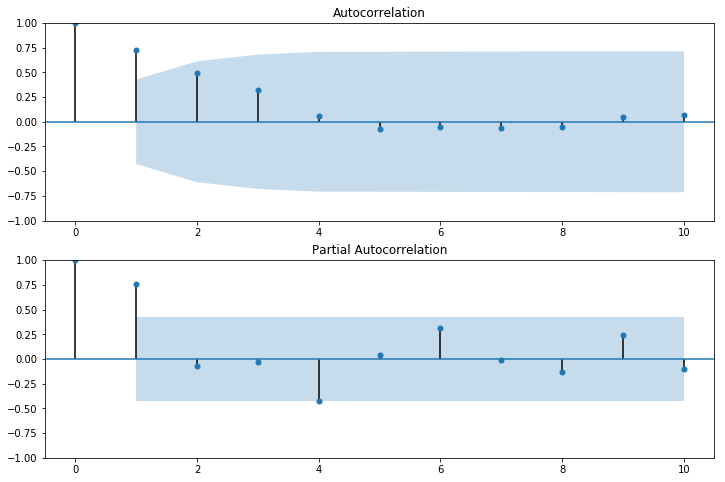

In [173]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
def predictability(y):
    maxlag = 10
    fig = pyplot.figure(figsize=(12,8))
    ax = fig.add_subplot(211)
    fig = plot_acf(y,lags=maxlag,ax=ax)
    pyplot.ylim(-1,1)
    ax = fig.add_subplot(212)
    fig = plot_pacf(y,lags=maxlag,ax=ax)
    pyplot.ylim(-1,1)
    pyplot.show()
    #fig = plot_acf(y)
    #fig.set_size_inches(14,10)
    #pyplot.figure(num=None,figsize=(20,12))
    #pyplot.show()
predictability(gold_price)

As shown above, the lag-1 is the cutoff predictability from 

# Reference
* [Datetime formate](https://docs.python.org/3/library/datetime.html)
* [partial autocorrelation explained](https://stats.stackexchange.com/questions/18599/pacf-manual-calculation)